In [16]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
#Time Series packages
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
#Clustering
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
#Folium map
import folium
from folium import plugins
from folium.plugins import HeatMap

In [5]:
#Loading and filtering out necessary information
df = pd.read_csv(r'C:/Users/rarun/Downloads/chicago.csv')
df = df [['ID', 'Date', 'Primary Type', 'Latitude', 'Longitude', 'Year', 'Community Area', 'Arrest']]


In [6]:
#Fixing Datetime format and removing 2019 data
df['Date'] = pd.to_datetime(df['Date'],format="%m/%d/%Y %H:%M:%S %p")
df = df[df['Year']<2019]
df['Month'] = pd.to_datetime((df.Date.dt.year*10000+df.Date.dt.month*100+1).apply(str),format='%Y%m%d')
df['Day'] = pd.to_datetime((df.Date.dt.year*10000+df.Date.dt.month*100+df.Date.dt.day).apply(str),format='%Y%m%d')


In [7]:
#Removing duplicates and NA values
df.drop_duplicates(subset=None, keep='first', inplace=True)
df.dropna(subset=['Latitude'], inplace=True)

In [8]:
df.shape
df.isna().sum()

ID                     0
Date                   0
Primary Type           0
Latitude               0
Longitude              0
Year                   0
Community Area    604291
Arrest                 0
Month                  0
Day                    0
dtype: int64

In [9]:
#pip install folium
#df = df.loc[0:3237407]

In [10]:
#con = df['Year']>2008
#df = df[con]
#con = df['Year']<2019
#df = df[con]

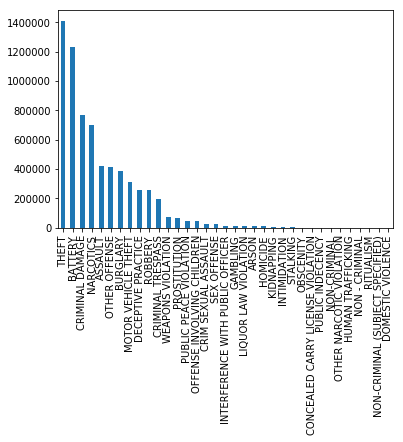

In [11]:
df['Primary Type'].value_counts().plot.bar()
# also need to check for un arrested cases

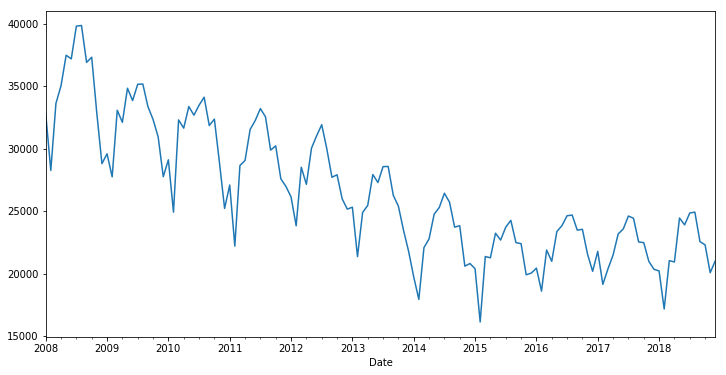

In [12]:
#Plotting Frequence of crimes over time (subsetted to months)
crime_freq = df[df['Date'].dt.year>2007].set_index('Date').resample('MS').size()
crime_freq.plot.line(figsize=(12,6))

In [13]:
time_ser = pd.DataFrame(columns = ['Date','CrimeCount'])
time_ser['Date'] = crime_freq.index
time_ser['CrimeCount'] = crime_freq.array

#Checking for Stationarity of time series 
#constant mean
#constant variance
#an autocovariance that does not depend on time.

def stationarity_check(t_series):
    #Determing rolling statistics
    rolmean = t_series.rolling(window=12).mean()
    rolstd = t_series.rolling(window=12).std()

    #Plot rolling statistics:
    orig = plt.plot(t_series, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(t_series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

stationarity_check(crime_freq)

#Trend
max_value=np.amax(crime_freq)
ts_log = np.log(crime_freq)
plt.plot(ts_log)
moving_avg = ts_log.rolling(window=12).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(12)

ts_log_moving_avg_diff.dropna(inplace=True)
stationarity_check(ts_log_moving_avg_diff)

expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log)
plt.plot(expwighted_avg, color='red')

ts_log_ewma_diff = ts_log - expwighted_avg
stationarity_check(ts_log_ewma_diff)

#Differencing
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

ts_log_diff.dropna(inplace=True)
stationarity_check(ts_log_diff)

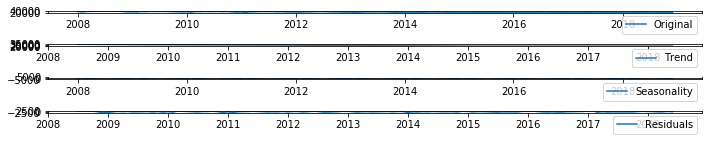

In [33]:
#DECOMPOSING THE TIME SERIES INTO ITS VARIOUS COMPONENTS

decomposition = seasonal_decompose(crime_freq)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.subplot(411)
plt.plot(crime_freq, label='Original')#, figsize=(8,3))
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [ ]:
decomposition = seasonal_decompose(crime_freq)
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
plt.plot(crime_freq, label='Original')
plt.plot(trend, label='Trend')
plt.plot(seasonal,label='Seasonality')
plt.plot(residual, label='Residuals')

lag_acf = acf(ts_log_diff, nlags=20)
lag_pacf = pacf(ts_log_diff, nlags=20, method='ols')

#Plot ACF: 
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122) 
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_log_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

#AR Model
model = ARIMA(ts_log, order=(1, 1, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_AR.fittedvalues-ts_log_diff)**2))

# MA model
model = ARIMA(ts_log, order=(0, 1, 1))  
results_MA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_MA.fittedvalues-ts_log_diff)**2))

#Combined model
model = ARIMA(ts_log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

predictions_ARIMA_log = pd.Series(ts_log.ix[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(crime_freq)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA-crime_freq)**2)/len(crime_freq)))

In [ ]:
df['Primary Type'].unique()

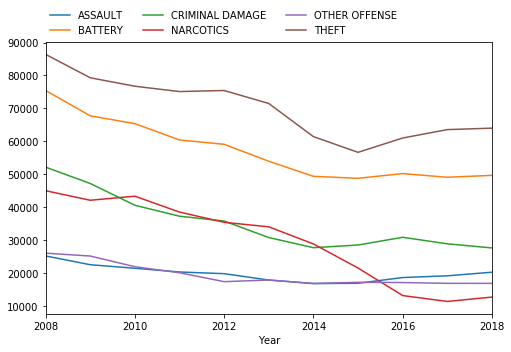

<Figure size 432x288 with 0 Axes>

In [36]:
# Plotting top 4 crimes across years
con = df['Primary Type'].isin(['THEFT','BATTERY','CRIMINAL DAMAGE','NARCOTICS','ASSAULT','OTHER OFFENSE'])
temp = df[con]
temp = temp[temp['Year']>2007]
crime_count = pd.crosstab(temp.Year,temp['Primary Type'])
crime_count.plot.line(figsize=(8,5))
plt.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3, 
            borderaxespad=0, frameon=False)
plt.show()
plt.savefig("figure.png")

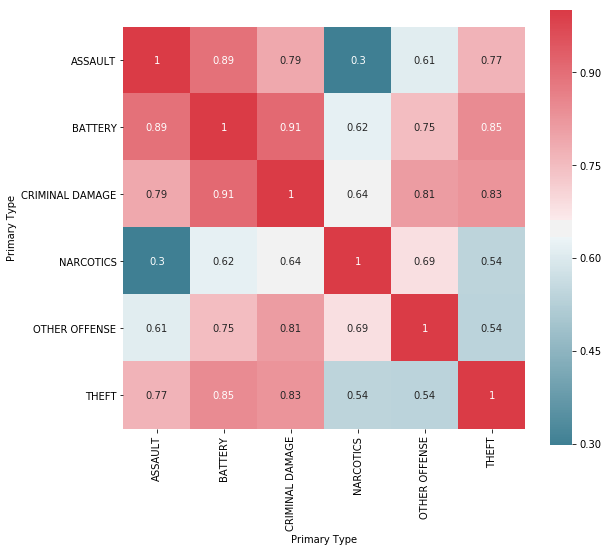

In [40]:
#calculate the correlation across months
crime_month_count = pd.crosstab(temp[temp['Year']>2008].Month,temp['Primary Type'])
fig, ax = plt.subplots(figsize=(9, 8))
corr = crime_month_count.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax, annot=True)

In [16]:
df['Primary Type'].unique()

array(['DECEPTIVE PRACTICE', 'CRIMINAL DAMAGE', 'BATTERY', 'THEFT',
       'CRIMINAL TRESPASS', 'WEAPONS VIOLATION', 'NARCOTICS', 'ROBBERY',
       'ASSAULT', 'LIQUOR LAW VIOLATION', 'MOTOR VEHICLE THEFT',
       'BURGLARY', 'CONCEALED CARRY LICENSE VIOLATION',
       'CRIM SEXUAL ASSAULT', 'OTHER OFFENSE',
       'OFFENSE INVOLVING CHILDREN', 'HOMICIDE', 'PUBLIC PEACE VIOLATION',
       'KIDNAPPING', 'ARSON', 'SEX OFFENSE',
       'INTERFERENCE WITH PUBLIC OFFICER', 'INTIMIDATION', 'PROSTITUTION',
       'STALKING', 'OBSCENITY', 'NON-CRIMINAL', 'PUBLIC INDECENCY',
       'GAMBLING', 'HUMAN TRAFFICKING', 'OTHER NARCOTIC VIOLATION',
       'NON-CRIMINAL (SUBJECT SPECIFIED)', 'NON - CRIMINAL', 'RITUALISM',
       'DOMESTIC VIOLENCE'], dtype=object)

CLUSTERING FOR SELECTED CRIMES & IDENTIFYING TARGET LOCATIONS FOR POLICE HEADQUARTERS

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


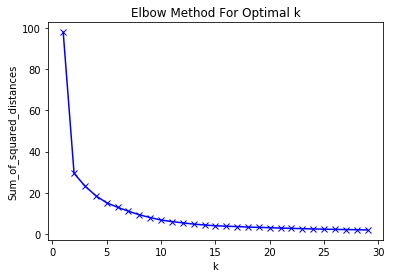

In [57]:
#Clustering for NARCOTICS
continuous_features = ['Latitude','Longitude']
con = df['Year'] == 2018
temp = df[con]
temp = temp[temp['Primary Type']=='NARCOTICS']
#temp
data = temp[['Latitude','Longitude']].reset_index()
data = data.drop('index', axis = 1)

data_transformed = data.values 

Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    print (k)
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

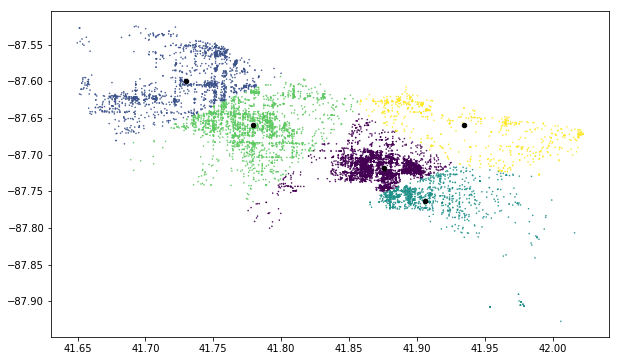

In [59]:
km = KMeans(n_clusters=5)
km = km.fit(data_transformed)
Sum_of_squared_distances.append(km.inertia_)
centers = km.cluster_centers_
plt.figure(figsize=(10,6))
y_kmeans = km.predict(data_transformed)
plt.scatter(data_transformed[:, 0], data_transformed[:, 1],  c=y_kmeans,s=0.3, cmap='viridis')
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=20, alpha=1);

In [46]:
data_transformed[:,0]
post_clust = pd.DataFrame()
post_clust['Latitude'] = data_transformed[:,0]
post_clust['Longitude'] = data_transformed[:,1]
post_clust['Class'] = y_kmeans

In [75]:

m = folium.Map(centers[0], zoom_start=12) #, tiles = "Stamen Terrain"
for i in centers:
    folium.Marker(i).add_to(m)


# Ensure you're handing it floats
#con = post_clust['Class']==1
df_acc = post_clust
df_acc['Latitude'] = df_acc['Latitude'].astype(float)
df_acc['Longitude'] = df_acc['Longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs

heat_df = df_acc[['Latitude', 'Longitude']]
heat_df = heat_df.dropna(axis=0, subset=['Latitude','Longitude'])

# List comprehension to make out list of lists
heat_data = [[row['Latitude'],row['Longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data, radius=0).add_to(m)

# Display the map
m.save(outfile="Narco_heat.html")

CLUSTERING FOR THEFT

In [79]:
#Clustering for THEFT
continuous_features = ['Latitude','Longitude']
con = df['Year'] == 2018
temp = df[con]
temp = temp[temp['Primary Type']=='THEFT']
#temp
data = temp[['Latitude','Longitude']].reset_index()
data = data.drop('index', axis = 1)
#whiten(data)
#mms = MinMaxScaler()
#mms.fit(data)
data_transformed = data.values 

Sum_of_squared_distances = []
K = range(1,30)
for k in K:
    print (k)
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed)
    Sum_of_squared_distances.append(km.inertia_)

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


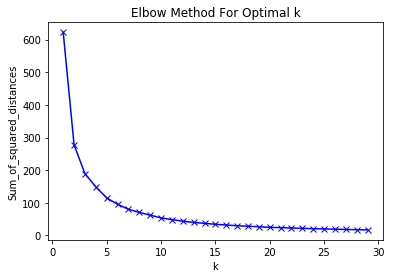

In [80]:
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

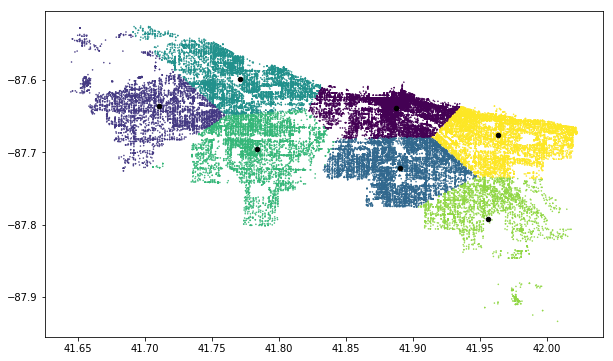

In [81]:
km = KMeans(n_clusters=7)
km = km.fit(data_transformed)
Sum_of_squared_distances.append(km.inertia_)


centers1 = km.cluster_centers_


y_kmeans = km.predict(data_transformed)
plt.figure(figsize=(10,6))

plt.scatter(data_transformed[:, 0], data_transformed[:, 1],  c=y_kmeans,s=0.3, cmap='viridis')
plt.scatter(centers1[:, 0], centers1[:, 1], c='black', s=20, alpha=1);

In [82]:
data_transformed[:,0]
post_clust = pd.DataFrame()
post_clust['Latitude'] = data_transformed[:,0]
post_clust['Longitude'] = data_transformed[:,1]
post_clust['Class'] = y_kmeans

In [83]:

m = folium.Map(centers1[0], zoom_start=12) #, tiles = "Stamen Terrain"
'''
icon = folium.features.CustomIcon(r'http://localhost:8888/view/medicine.png',
                                      icon_size=(14, 14))
for i in centers1:
    folium.Marker(i,icon=folium.Icon(color='green')).add_to(m)#
for i in centers:
    folium.Marker(i,icon=folium.Icon(color='blue')).add_to(m)

'''
# Ensure you're handing it floats
#con = post_clust['Class']==4
df_acc = post_clust
df_acc['Latitude'] = df_acc['Latitude'].astype(float)
df_acc['Longitude'] = df_acc['Longitude'].astype(float)

# Filter the DF for rows, then columns, then remove NaNs

heat_df = df_acc[['Latitude', 'Longitude']]
heat_df = heat_df.dropna(axis=0, subset=['Latitude','Longitude'])

# List comprehension to make out list of lists
heat_data = [[row['Latitude'],row['Longitude']] for index, row in heat_df.iterrows()]

# Plot it on the map
HeatMap(heat_data, radius=0).add_to(m)

# Display the map
#m

m.save(outfile='centroids.html')


REGION WISE HEAT MAP FOR COMMUNITIES

In [29]:
#GeoJson file for chloropleth map
#https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Neighborhoods/bbvz-uum9

In [30]:
temp = df.dropna()

In [31]:
temp['Community Area']

135004     67.0
135005     74.0
135006     71.0
135007     31.0
135008     71.0
135009     25.0
135010     71.0
135011      5.0
135012     23.0
135013      6.0
135014      3.0
135015     69.0
135016     19.0
135017     44.0
135018      1.0
135019     29.0
135020     28.0
135021     66.0
135022     16.0
135023      6.0
135024     73.0
135025     71.0
135026      8.0
135027     70.0
135028     73.0
135029     15.0
135030      8.0
135031     25.0
135032     30.0
135033     23.0
           ... 
6920760     1.0
6920762     7.0
6920764    19.0
6920766    61.0
6920768    27.0
6920769    28.0
6920770    69.0
6920771    49.0
6920773    29.0
6920775    25.0
6920777    29.0
6920779    22.0
6920781    67.0
6920783    28.0
6920785    46.0
6920787    29.0
6920789    67.0
6920791    70.0
6920793    59.0
6920795    61.0
6920797    62.0
6920799     1.0
6920801    28.0
6920803    23.0
6920805    39.0
6920807    19.0
6920809    27.0
6920811    23.0
6920813    75.0
6920828    76.0
Name: Community Area, Le

In [33]:
district_geo = r'Boundaries - Neighborhoods.geojson'
temp_reg = df.dropna()
# calculating total number of incidents per district
crimedata2 = pd.DataFrame(temp_reg['Community Area'].value_counts().astype(float))
crimedata2.to_json('crimeagg.json')
crimedata2 = crimedata2.reset_index()
crimedata2.columns = ['District', 'Number']
  
# creation of the choropleth
map1 = folium.Map(location=centers[0], zoom_start=12)
map1.geo_json(geo_path = district_geo, 
              data_out = 'crimeagg.json', 
              data = crimedata2,
              columns = ['Community Area', 'Number'],
              key_on = 'feature.properties.DISTRICT',
              fill_color = 'YlOrRd', 
              fill_opacity = 0.7, 
              line_opacity = 0.2,
              legend_name = 'Number of incidents per district')
               
display(map1)

AttributeError: 'Map' object has no attribute 'geo_json'

In [66]:

m1 = folium.Map(location=[40.66393072,-73.93827499], zoom_start=13)

folium.TopoJson(
    open(r'Boundaries - Neighborhoods.geojson'),
    object_path=r'crimeagg.json',
).add_to(m1)

m1

AttributeError: 'NoneType' object has no attribute 'get'